In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2, warnings
from natsort import natsorted
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from numpy.random import Generator, PCG64
rng_pg = Generator(PCG64())
from scipy.optimize import newton, minimize, fsolve
from scipy.optimize import nnls
import statsmodels.api as sm
import statsmodels.formula.api as smf


### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("notebook")
%matplotlib inline

from wand.image import Image as WImage

In [2]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)
from src.stats_collection import STATS_collection
from src.plotting import TRNA_plot
from src.curve_fitting import loss_func_c1, loss_func_l1, loss_func_l2, hl_bsl_fit, lin_fit_off, obj_lin_fit_off, bootstrap_hl, bootstrap_hl_fast

# These are default folder names for data and raw fastq files
# relative to the folder in which this notebook is in:
data_dir = 'data'
stats_dir = 'stats_collection'
plotting_dir = 'plotting'

Notebook is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/charge_titration
Repo is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq


# Charge titration to validate tRNA-charge sequencing approach
In this notebook I will process and analyze the samples generated to validate the tRNA-charge sequencing approach.
The summary of the finding of this analysis is:
* tRNA oxidation/cleavage goes to completion, thus the initial step of charge discrimination is quantitative 
* tRNA abundance is affected by the oxidation/cleavage reactions but relative abundance is comparable between samples that have undergone the same treatment
* tRNA charge can be determined quantitatively


### Sample description
To generate samples with known tRNA acetylation leves a mixture of intact and deacetylated tRNA was made.
The intact tRNA was isolated from a cell culture, split in two and one part deacylated before mixing them together at different ratios.
A titration was made to establish a linear range of tRNA charging quantification.
The titration spans 8 different ratios: 100/0, 85/15, 70/30, 55/45, 40/60, 25/75, 10/90, 0/100 of percentage charge/uncharge.

If there is a adapter ligation bias, this should reveal itself as a deviation from linearity between predicted and measured tRNA charge.
Because the substrate is a complex mix of tRNAs isolated from a cell culture, it will be possible to reveal ligation bias on the transcript level.



#### Protocol for preparing the tRNA titration
1. Isolate whole cell RNA from adherent cells using Trizol. Place dish on ice, thoroughly aspirate media, then add enough Trizol to cover the cells. From this point onwards, keep the RNA cold and work fast to retain tRNA acylation. Scrape cells and move to tube, add chloroform, vortex 5 min and spin. Precipitate RNA with IPA, spin and wash the pellet twice in acetate buffered 80% IPA (pH=4.5), then do a final wash in 100% IPA and dry RNA pellet. Dry RNA pellets can be stored at -80C for months without detectable loss of acetylation.
2. Prepare deacetylated tRNA by taking a tube with whole cell RNA, reconstituting it with 100 mM sodium acetate, pH=4.5, measure the RNA concentration and adjust it to 1 ug/uL. Add 50 uL 1M lysine (pH=8) per 10 uL RNA and incubate 4 h at 45C. After incubation, lower the pH by adding 10 uL 11 M sodium acetate per 10 uL RNA, then precipitate, wash and reconstitute with 100 mM sodium acetate, pH=4.5, measure the RNA concentration and adjust it to 1 ug/uL.
3. Prepare intact tRNA by taking a tube with whole cell RNA and reconstituting it with 100 mM sodium acetate, pH=4.5, measure the RNA concentration and adjust it to 1 ug/uL.
4. Make a titration of the following percentages of intact/deacylated RNA: 100/0, 85/15, 70/30, 55/45, 40/60, 25/75, 10/90, 0/100
5. Perform periodate oxidation, including adding E.coli control, and subsequent steps following the tRNA-charge-seq protocol with the appropriate scaling
6. At the adapter ligation step, use multiple adapters for each titration ratio to get barcode level replicates


### Read and filter input data
A sample list is provided to filter the samples for further use and add relevant sample level information.
The data is read from a .csv file with aggregated sample statistics.
This .csv file was generated using the standard process described in the tRNA-seq-charge repo and is the result of using the `STATS_collection` class.
Below the `TRNA_plot` class is used to extract the relevant tRNA charge information at transcript level.

In [3]:
sample_list_fnam = 'sample_list.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))
sample_df['run_v1'] = np.array([fn[0:10] == '2022-12-28' for fn in sample_df['fastq_mate1_filename']])

# Make a dictionary with paths used for data processing:
dir_dict = dict(NBdir = NBdir,
                data_dir = data_dir,
                stats_dir = stats_dir,
                plotting_dir = plotting_dir)

# Get charge dataframe for aggregated stats:
plot_obj = TRNA_plot(dir_dict, sample_df=sample_df, \
                     stats_fnam='ALL_stats_aggregate.csv', \
                     overwrite_dir=False)
plot_obj.get_charge_df()

# Add E.coli control RPM to sample level information:
ectr = plot_obj.charge_filt['tr'][plot_obj.charge_filt['tr']['Ecoli_ctr']].copy()
sample_df = ectr.loc[:, ['sample_name_unique', 'RPM']].merge(sample_df, on='sample_name_unique')
sample_df = sample_df.rename(columns={'RPM': 'RPM_Ectr'}, errors='ignore')

# Extract dataframe with charge and add sample information:
charge_df = sample_df.loc[:, ['sample_name_unique', 'hue_value', \
                              'hue_order', 'RPM_Ectr', 'plot_group', \
                              'run_v1']].merge(plot_obj.charge_filt['tr'], on='sample_name_unique')
charge_df['tRNA_anno_short'] = ['mito-'+an if mc else an for an, mc in zip(charge_df['tRNA_anno_short'], charge_df['mito_codon'])]
charge_df['RPM_norm'] = charge_df['RPM'] / charge_df['RPM_Ectr']

# Convert percent charged to an integer value,
# and isolate the titration samples:
mask = (charge_df['plot_group'] == 'Charge-titration') & ~(charge_df['sample_name'] == '100p')
titr_df = charge_df[mask].copy()
frac_list = list()
for sn in titr_df['sample_name']:
    try:
        frac_list.append(int(sn[0:3]))
        continue
    except:
        pass
    try:
        frac_list.append(int(sn[0:2]))
        continue
    except:
        pass
    try:
        frac_list.append(int(sn[0:1]))
        continue
    except:
        raise Exception('???')
titr_df['percent_charged'] = frac_list
charge_df['percent_charged'] = None
charge_df.loc[mask, 'percent_charged'] = frac_list

Folder exists and overwrite set to false... Doing nothing.


In [4]:
# Enforce minimum read count:
min_count = 1000
# For each tRNA annotation, find samples
# that have above the minimum count:
tann2snu = dict()
for snu, tann, ectr, cnt in zip(titr_df['sample_name_unique'], \
                                titr_df['tRNA_annotation'], \
                                titr_df['Ecoli_ctr'], \
                                titr_df['count']):
    if ectr or cnt <= min_count:
        continue
    
    if tann in tann2snu:
        tann2snu[tann].add(snu)
    else:
        tann2snu[tann] = set()
        tann2snu[tann].add(snu)

# Filter tRNA annotation based on
# all samples having above the minimum count:
all_snu = set(titr_df['sample_name_unique'])
tann_sele = set()
for tann in tann2snu:
    if tann2snu[tann] == all_snu:
        tann_sele.add(tann)
mask = (titr_df['tRNA_annotation'].isin(tann_sele))
titr_df = titr_df[mask].copy()

### Discussion on the different failure modes of tRNA-charge sequencing

tRNA-charge sequencing relies on NaIO4 oxidation and base cleavage but this reaction has many failure modes.
To investigate these, imagine a sample were the charge is 90%, e.g. 90 charged molecules, 10 uncharged.
We can think of five important failure modes which result in different errors in the measurement:
1. Oxidation does not run to completion: Some uncharged tRNAs that should have been converted to "CC" remain "CCA", thus charge appears higher than 90%.
    * Can be tested by spike-in of an uncharged tRNA, any "CCA" remaining is a sign of incomplete oxidation.
    * Will also show in fully deacylated samples.
    * **Incomplete oxidation => charge overestimate**
2. Base cleavage/dephosphorylation does not run to completion: Some of the uncharged tRNAs that were oxidized does not get cleaved or dephosphorylated. This blocks ligation and they drop out of the sample, and thus charge appears higher than 90%.
    * Can be tested indirectly by performing oxidation/cleavage/dephosporylation and subsequent ligation on a tRNA sample. Assuming complete oxidation and barcode ligation, incomplete cleavage/dephosporylation would show as decrease in ligation efficiency.
    * Can also be tested directly by using a tRNA oligo and observing the 1 nt. truncation on a gel.
    * The only spike-in that would reveal this effect is one with a known ratio of charged/uncharged tRNA. Uncharged spike-in will not help here because only the cleaved tRNAs with "CC" ending will be available for adapter ligation.
    * **Incomplete cleavage => charge overestimate**
3. Low RNA integrity: RNA stability during processing steps prior to adapter ligation causes the tRNA to lose the 3’ A, thus the charge appears lower than 90%.
    * This can be tested using NaCl instead of NaIO4 and otherwise following all the downstream steps identically; however, degradation can both cause "CC" and "CCA" to degrade and get under counted and therefore the magnitude of the effect depends on the charging fraction itself.
    * **Low RNA integrity => charge underestimate**
4. Adapter ligation is biased: adapter ligation is preferential to "CCA" over the shorter "CC" thus enriching for "CCA" endings and thus charge appears higer than 90%.
    * Can be tested by mixing a known quantity of charged and uncharged tRNA. A barcode with ligation bias would be picked out as deviating from the others.
    * Ligation bias could also be on the 3' end C vs. A, but this is less likely for splint based ligation used here.
    * **Barcode CCA preference => charge overestimate**
5. Deacylation is incomplete: Some of the charged tRNAs are blocked for ligation because of the aminoacylation, thus charge appears lower than 90%.
    * This can be tested by performing the protocol using an pre-deacylated RNA sample that have undergone the same deacylation as the protocol. If the pre-deacylation is incomplete, then the deacylation following the oxidation step will free more tRNAs with "CCA" endings and the sample will appear charged.
    * **Incomplete deacylation => charge underestimate**

These five points all involve methodological failures, but biological abnormalities can also be encountered.
The most relevant abnormality to consider is that surrounding the CCA-end of the tRNA which is attached post-transcriptionally and is not error-free.
For example if the CCA-end was prematurely terminated such that it appears as a truncated CC-end, then it would lead to the tRNA being annotated as uncharged.

In the sections below we will evaluate the likelihood of each of the five failure modes and, as a side product of the analysis of the control samples, we will also investigate the possiblity of biological abnormalities.

### Analysis of control samples
Plotting the "charge" of the E.coli control tRNA in each sample.
This is addressing tRNA-charge sequencing failure mode 1 (see above).

The E.coli control was added to check that the NaIO4 oxidation and lysine cleavage reaction goes to completion and therefore should appear as 0% charged (i.e. all CC, no CCA); however, typically, a smaller percentage remains intact and thus will appear as charged.
This, is also apparent below where most samples have a measured charge for the E.coli control samples of ~1% and no samples are above 2%.
Whether this small residual "charge" reflects the incompletion of the NaIO4 oxidation and lysine cleavage reaction or is a sequencing artifact is unknown, but we take it that the levels are so low that for most pratical purposes, including this analysis, the reaction can be assumed complete.
This conclusion is also supported by data using fully deacylated samples (see further down).

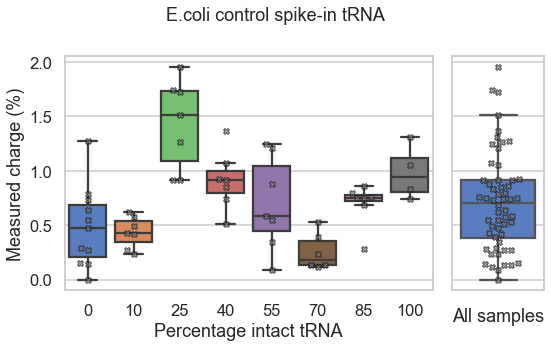

In [5]:
# Select E.coli controls samples:
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(8, 5))
    gs = fig.add_gridspec(1, 2, width_ratios=[4, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    
    ectr_mask = (charge_df['Ecoli_ctr']) & ~(charge_df['sample_name'] == '100p') & \
                (charge_df['plot_group'] == 'Charge-titration')

    # Plot charge split on percentage intact tRNA:
    g1 = sns.boxplot(ax=ax1, data=charge_df[ectr_mask], x='percent_charged', y='charge', \
                     fliersize=False)
    g1 = sns.swarmplot(ax=ax1, data=charge_df[ectr_mask], x='percent_charged', y='charge', \
                       color='grey', alpha=0.7, edgecolor='black', dodge=True, \
                       linewidth=0.8, size=6, marker='X', warn_thresh=1)
    g1.set(ylabel='Measured charge (%)', xlabel='Percentage intact tRNA')

    # Plot for all samples:
    g2 = sns.boxplot(ax=ax2, data=charge_df[ectr_mask], y='charge', \
                     fliersize=False)
    g2 = sns.swarmplot(ax=ax2, data=charge_df[ectr_mask], y='charge', \
                       color='grey', alpha=0.7, edgecolor='black', dodge=True, \
                       linewidth=0.8, size=6, marker='X', warn_thresh=1)
    g2.set(ylabel='', xlabel='All samples')
    plt.setp(ax2.get_yticklabels(), visible=False)
    fig.suptitle('E.coli control spike-in tRNA', size=18);
    
    fig.tight_layout()
    fig.savefig('data/plotting/ecoli-control_charge.pdf', bbox_inches='tight')

The problem with the E.coli spike-in tRNA is that it is a synthesized oligo with synthesis associated erros such as truncations, unremoved protection groups and side-reaction products.
Althought it is PAGE purified there is no guarantee that it does not have a significant proportion of synthesis errors.

Another way to test if the oxidation has run to completion, to address tRNA-charge sequencing failure mode 1 (see above), is to use fully deacylated tRNA.
Such samples should contain tRNAs with 0% charge; however, in practice 0% is almost never measured, as we will see below.

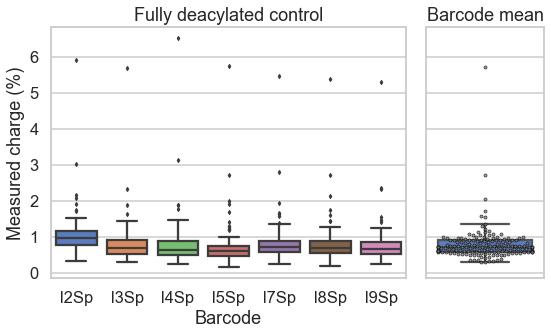

In [6]:
# Plot the charge of the
# fully deacylated samples:
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(8, 5))
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    
    # Find the mean/max charge for the two types 
    # of fully deacylated samples:
    zerom = (charge_df['sample_name'] == '0p') & (~charge_df['Ecoli_ctr']) & (charge_df['RPM'] > 1000)
    zero_df = charge_df[zerom].groupby('tRNA_annotation').agg(charge_mean=('charge', 'mean'), \
                                                              charge_max=('charge', 'max')).reset_index()
    zerom_90m = (charge_df['sample_name'] == '0p_90m') & (~charge_df['Ecoli_ctr']) & (charge_df['RPM'] > 1000)
    zero_df_90m = charge_df[zerom_90m].groupby('tRNA_annotation').agg(charge_mean=('charge', 'mean'), \
                                                                      charge_max=('charge', 'max')).reset_index()

    # Plot charge split on barcodes:
    bc_order = natsorted(set(charge_df.loc[zerom, 'barcode']))
    g1 = sns.boxplot(ax=ax1, data=charge_df[zerom], x='barcode', y='charge', \
                     fliersize=3, order=bc_order)
#    g1 = sns.swarmplot(ax=ax1, data=charge_df[zerom], x='barcode', y='charge', \
#                       color='grey', alpha=0.7, edgecolor='black', dodge=True, \
#                       linewidth=0.8, size=2, warn_thresh=1, \
#                       order=bc_order)
    g1.set(ylabel='Measured charge (%)', xlabel='Barcode')
    g1.set_title('Fully deacylated control')

    # Plot barcode average:
    g2 = sns.boxplot(ax=ax2, y=zero_df['charge_mean'].values, fliersize=False)
    g2 = sns.swarmplot(ax=ax2, y=zero_df['charge_mean'].values, \
                       color='grey', alpha=0.7, edgecolor='black', \
                       linewidth=0.8, size=3, warn_thresh=1)
    g2.set_title('Barcode mean')
    plt.setp(ax2.get_yticklabels(), visible=False)
    
    fig.tight_layout()
    fig.savefig('data/plotting/deacylated-control_charge.pdf', bbox_inches='tight')

So it appears that there is one obvious outlier; but otherwise, the distribution is very similar to the one for the E.coli spike-in samples, with majority of the measurements below 1%.
It turns out that the outlier is mito-Met, also known as fMet because of the methionine formylation.
This tRNA aminoacylation has a particularly high half-life i.e. it is very stable (see the `charge_half-life` folder under projects).
Therefore, it is likely that the result is because this tRNA was actually not fully deacylated.
We will investigate this later, but first observe the tRNAs with the highest mean charge in the fully deacylated samples as listed below.
The first is fMet, as predicted by its long half-life, then follows mostly mitochondrial tRNAs.

In [7]:
zero_df.sort_values('charge_mean', ascending=False).head(10)

,tRNA_annotation,charge_mean,charge_max
11,Homo_sapiens_mito_tRNA-Met-CAT,5.715828,6.523327
7,Homo_sapiens_mito_tRNA-Ile-GAT,2.730072,3.148956
12,Homo_sapiens_mito_tRNA-Phe-GAA,2.050101,2.340851
15,Homo_sapiens_mito_tRNA-Trp-TCA,1.718043,2.093135
5,Homo_sapiens_mito_tRNA-Gly-TCC,1.584081,1.921855
16,Homo_sapiens_mito_tRNA-Val-TAC,1.558633,1.919688
2,Homo_sapiens_mito_tRNA-Asp-GTC,1.347286,1.478353
80,Homo_sapiens_tRNA-Ile-AAT-7-1,1.294310,1.630989
140,Homo_sapiens_tRNA-Tyr-GTA-1-1,1.227653,1.359192
144,Homo_sapiens_tRNA-Val-AAC-3-1,1.172705,1.360030


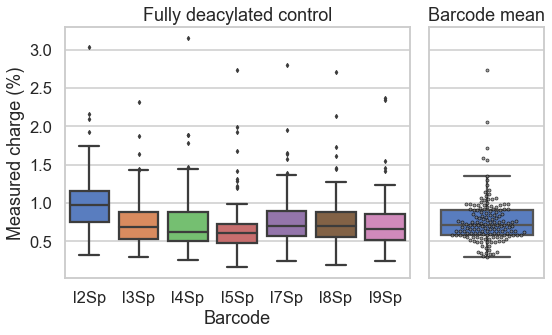

In [8]:
# Plot the charge of the
# fully deacylated samples without the fMet:
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(8, 5))
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    
    # Find the mean/max charge for the two types 
    # of fully deacylated samples:
    fMet_mask = (charge_df['sample_name'] == '0p') & \
                (~charge_df['Ecoli_ctr']) & \
                (charge_df['RPM'] > 1000) & \
                (charge_df['tRNA_anno_short'] != 'mito-Met-CAT')
    zero_df_fMet = charge_df[fMet_mask].groupby('tRNA_annotation').agg(charge_mean=('charge', 'mean'), \
                                                                       charge_max=('charge', 'max')).reset_index()
    # Plot charge split on barcodes:
    bc_order = natsorted(set(charge_df.loc[fMet_mask, 'barcode']))
    g1 = sns.boxplot(ax=ax1, data=charge_df[fMet_mask], x='barcode', y='charge', \
                     fliersize=3, order=bc_order)
#    g1 = sns.swarmplot(ax=ax1, data=charge_df[zerom], x='barcode', y='charge', \
#                       color='grey', alpha=0.7, edgecolor='black', dodge=True, \
#                       linewidth=0.8, size=2, warn_thresh=1, \
#                       order=bc_order)
    g1.set(ylabel='Measured charge (%)', xlabel='Barcode')
    g1.set_title('Fully deacylated control')

    # Plot barcode average:
    g2 = sns.boxplot(ax=ax2, y=zero_df_fMet['charge_mean'].values, fliersize=False)
    g2 = sns.swarmplot(ax=ax2, y=zero_df_fMet['charge_mean'].values, \
                       color='grey', alpha=0.7, edgecolor='black', \
                       linewidth=0.8, size=3, warn_thresh=1)
    g2.set_title('Barcode mean')
    plt.setp(ax2.get_yticklabels(), visible=False)
    
    fig.tight_layout()
    fig.savefig('data/plotting/deacylated-control_charge_nofMet.pdf', bbox_inches='tight')

Let us do a more formal analysis to try and explain the mean transcript charge of the fully deacylated samples.
The aminoacylation stability, or half-life, is obviously a factor to consider.
Recall the decay function (or reactant consumption) of a first order reaction:
$$
N(t) = N_0 \left( \frac{1}{2} \right) ^\frac{t}{t_{1/2}}
$$

The deacylated RNA has undergone the same deacylation step as the tRNA-charge sequencing protocol: pH=8 lysine at 45C for 4 hours.
The aminoacylation half-life should be so small under these circumstances that the deacylation is complete but what if it is not?
Let us use an example and assume a tRNA transcript that is 100% charged and has a half-life of 40 min under the deacylation conditions.
After 4 hours 1.5625% remains charged:
$$
N(4) = 100 \left( \frac{1}{2} \right) ^\frac{4}{2/3} = 1.5625
$$

Thus, when this tRNA transcript is being used in the tRNA-charge sequencing protocol 1.5625% is protected from oxidation whilst 98.4375% is truely uncharged and therfore oxidized.
Now, the in following step of lysine cleavage the same 4 h lysine incubation is taking place as under the first deacylation, and here some of the 1.5625% charged tRNA is getting deacylated.
In fact almost all the charged tRNA is getting deacylated:
$$
N(4) = 1.5625 \left( \frac{1}{2} \right) ^\frac{4}{2/3} = 0.0244140625
$$

Now, the 100% of the tRNA transcript has turned into 98.4375% CC-ending, 1.5380% CCA-ending and 0.0244% remains charged.
In the next step barcode ligation is performed and the charged tRNA is blocked from ligation and thus drops out.
In the end after sequencing the charge is calculated as CCA/(CCA+CC):
$$
1.5380 / (1.5380 + 98.4375) * 100 = 1.5384
$$


This shows that the measured charge of the deacylated samples can possibly be explained by the aminoacylation half-life.
We can then use the aminoacylation half-lifes for each transcript (see the charge_half-life folder under projects) and use it as a feature in a linear model.
In that case the decay function must be log transformed to make the left side linearly dependent on the half-life $t_{1/2}$:
$$
log_2(N(t)) = log_2(N_0) - t \frac{1}{t_{1/2}}
$$


But there are also other possible explanations for the apparent incomplete deacylation.
Beyond incomplete oxidation, which is discussed above, the tRNA could have biological imperfections i.e. deviations from the normal CCA-ending.
There is indeed precedence for this and it turns out that the CCA-adding enzyme is far from perfect.
In a study by [Wende et al. 2015](https://academic.oup.com/nar/article/43/11/5617/1175316), they quantify these errors using sequencing and conclude that variables such as the base before the CCA (called the discriminator base), the first two bases and tRNA length and shape can influence the fidelity of the CCA-adding enzyme.
They find that, among several errors, tRNAs ending in CCAC is common.
This would result in the tRNA being falsely annotated as aminoacylated because the 3' C is removed during oxidation/base cleavage.

It is also interesting to note that there is likely only one human CCA-adding enzyme with two splice variants, one in the nucleus and one in the mitochondria.
This means that the same CCA-adding enzyme both cytoplasmic and mitochondrial tRNAs despite the large sequence differences between the tRNAs in the two compartments.

Now we are ready to fit the model which is done below.

In [9]:
# Load previously calculated half-lifes.
# Not with fMet included, as this is a two-species model.
hl_df = pd.read_csv('../charge_half-life/acylation_half-lifes_features.csv')
hl_df = hl_df.merge(zero_df, on='tRNA_annotation')
hl_df['discr_base_C'] = (hl_df['discr_base'] == 'C')
hl_df['fs_GG'] = (hl_df['first_base'] == 'G') & (hl_df['second_base'] == 'G')
hl_df['len_long'] = (hl_df['tRNA_annotation_len'] > 84)
hl_df['len_mid'] = (hl_df['tRNA_annotation_len'] < 84) & (hl_df['tRNA_annotation_len'] > 73)
hl_df['len_short'] = (hl_df['tRNA_annotation_len'] <= 73)

In [10]:
# Run OLS:
results = smf.ols('np.log2(charge_mean) ~ fs_GG + len_long + len_mid + len_short + np.divide(-1, hl) + discr_base_C + mito_codon', data=hl_df).fit()
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     np.log2(charge_mean)   R-squared:                       0.639
Model:                              OLS   Adj. R-squared:                  0.623
Method:                   Least Squares   F-statistic:                     42.11
Date:                  Mon, 20 Mar 2023   Prob (F-statistic):           2.75e-29
Time:                          14:57:09   Log-Likelihood:                -34.241
No. Observations:                   150   AIC:                             82.48
Df Residuals:                       143   BIC:                             103.6
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept   

In [11]:
# Run OLS with only significant features:
results = smf.ols('np.log2(charge_mean) ~ np.divide(1, hl) + discr_base_C + mito_codon + len_long', data=hl_df).fit()
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     np.log2(charge_mean)   R-squared:                       0.638
Model:                              OLS   Adj. R-squared:                  0.628
Method:                   Least Squares   F-statistic:                     63.97
Date:                  Mon, 20 Mar 2023   Prob (F-statistic):           4.53e-31
Time:                          14:57:09   Log-Likelihood:                -34.305
No. Observations:                   150   AIC:                             78.61
Df Residuals:                       145   BIC:                             93.66
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept   

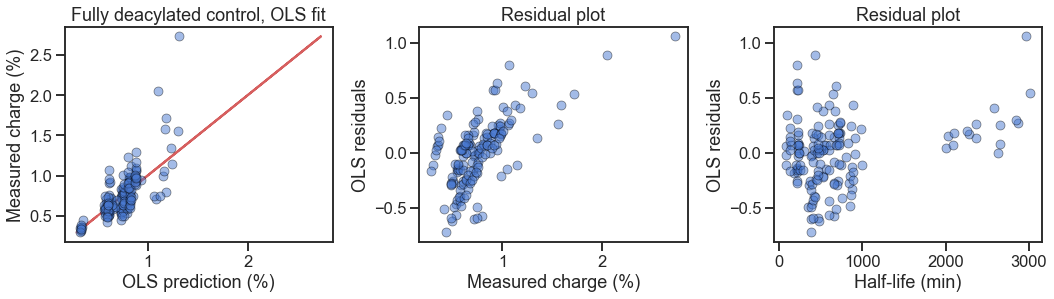

In [12]:
# Plot OLS fit and diagnostics:
fig = plt.figure(figsize=(15, 4.5))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

charge_mean_pred = 2**results.predict()

# OLS fit:
g1 = sns.scatterplot(ax=ax1, x=charge_mean_pred, y=hl_df['charge_mean'], \
                     zorder=10, alpha=0.5, \
                     edgecolor='black', linewidth=0.7, legend=False)
g1.set_title('Fully deacylated control, OLS fit')
g1.set(xlabel='OLS prediction (%)', ylabel='Measured charge (%)')
ax1.plot(hl_df['charge_mean'], hl_df['charge_mean'], c='r', zorder=1)

# OLS residuals:
g2 = sns.scatterplot(ax=ax2, y=results.resid, x=hl_df['charge_mean'], \
                     zorder=10, alpha=0.5, \
                     edgecolor='black', linewidth=0.7, legend=False)
g2.set_title('Residual plot')
g2.set(ylabel='OLS residuals', xlabel='Measured charge (%)')

# OLS residuals vs half-life:
g3 = sns.scatterplot(ax=ax3, y=results.resid, x=hl_df['hl'], \
                     zorder=10, alpha=0.5, \
                     edgecolor='black', linewidth=0.7, legend=False)
g3.set_title('Residual plot')
g3.set(ylabel='OLS residuals', xlabel='Half-life (min)')

fig.tight_layout()

The conclusion from the linear model is that it is not very good at explaining the measured charge i.e. indicating that it arises from a process not covered by the features used, or simply is dominated by noise.
The residual plot (middle panel above) suggests that it is not just random noise as the residuals are not normally distributed.
The other residual plot (right panel above) shows that the residuals are independent from the half-life.

The model coefficients suggest to us the following:
1. Smaller half-life => lower mean charge
2. Long tRNAs (Leu/Ser) and C as discriminator base (Cys/Gln/Thr) => lower mean charge
3. Mitochondrial tRNAs => higher mean charge

The coefficient for the half-life is as predicted cf. above discussion.
The other results can be taken to mean that long tRNAs and T as discriminator base makes the CCA-adding enzyme _less_ likely to erroneously add CCAC, whereas the CCA-adding enzyme is _more_ likely to erroneously add CCAC onto mitochondrial tRNAs.
But this is all very speculative.

Although, the linear model does not fully explain the measured charge in the deacylated samples it does show that it is not driven by the half-life (with the possible exception of fMet) and since it is such a small value we do not believe it contributes substantially to the measurement error of the tRNA-charge sequencing method.
Thus, we have covered failure mode 1 and 5 in the discussion above.

Next we will look at failure mode 3 using samples prepared with sham oxidation using NaCl instead of NaIO4.

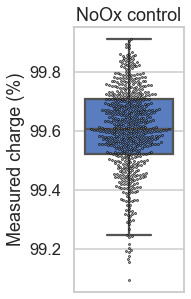

In [13]:
# Plot the charge for the
# non-oxidized control samples:
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(3, 4.5))
    noxm = (charge_df['sample_name'] == '40h_NoOx') & (~charge_df['Ecoli_ctr']) & (charge_df['RPM'] > 1000)
    g1 = sns.boxplot(ax=ax1, y=charge_df.loc[noxm, 'charge'].values, fliersize=False)
    g1 = sns.swarmplot(ax=ax1, y=charge_df.loc[noxm, 'charge'].values, \
                       color='grey', alpha=0.7, edgecolor='black', \
                       linewidth=0.8, size=2)
    g1.set(ylabel='Measured charge (%)')
    g1.set_title('NoOx control')
    fig.tight_layout()
    fig.savefig('data/plotting/NoOx-control_charge.pdf', bbox_inches='tight')

Failure mode 3 posits that RNA degradation leads to charge underestimates because A is removed from the CCA-end due to hydrolysis or nuclease activity.
The no oxidation control will elucidate such failure because all tRNAs remain intact and thus should appear 100% charged.
We can observe from the above that the measured charge on the non-oxidized controls is >99%, and in most instances >99.5%.
We consider this a good indicator that RNA integrity is high and thus this further supports the findings of little RNA degradation using gels.

Although the measured charge is very close to 100% one might still ask what explains the difference.
We could propose that the small difference is indeed due to hydrolysis or nuclease activity, but it could also be other things such as biological abnormalities in the CCA-end.
We investigate this using a linear model.

In [14]:
# Run OLS to predict the "missing" charge
# in the non-oxidized controls:
noxm = (charge_df['sample_name'] == '40h_NoOx') & (~charge_df['Ecoli_ctr']) & (charge_df['RPM'] > 1000)
in_df = charge_df[noxm].groupby(['tRNA_annotation']).agg(intact_charge=('charge', 'mean')).reset_index()
hl_df = hl_df.merge(in_df, on='tRNA_annotation', how='inner', copy=False, suffixes=(None, '_y'))
hl_df['degrad_charge'] = 100 - hl_df['intact_charge']
results = smf.ols('degrad_charge ~ fs_GG + len_long + len_mid + len_short + mito_codon + discr_base', data=hl_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          degrad_charge   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     14.31
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           5.72e-14
Time:                        14:57:11   Log-Likelihood:                 150.31
No. Observations:                 149   AIC:                            -284.6
Df Residuals:                     141   BIC:                            -260.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2761      0

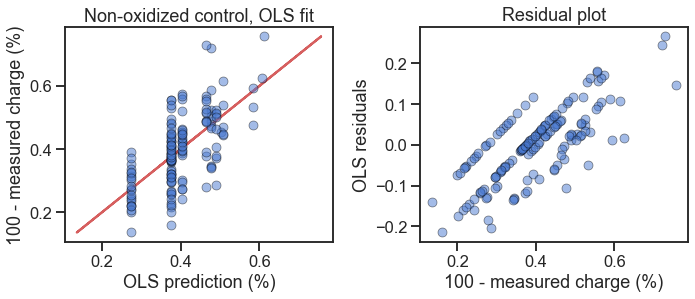

In [15]:
# Plot OLS fit and diagnostics:
fig = plt.figure(figsize=(10, 4.5))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# OLS fit:
g1 = sns.scatterplot(ax=ax1, x=results.predict(), y=hl_df['degrad_charge'], \
                     zorder=10, alpha=0.5, \
                     edgecolor='black', linewidth=0.7, legend=False)
g1.set_title('Non-oxidized control, OLS fit')
g1.set(xlabel='OLS prediction (%)', ylabel='100 - measured charge (%)')
ax1.plot(hl_df['degrad_charge'], hl_df['degrad_charge'], c='r', zorder=1)

# OLS residuals:
g2 = sns.scatterplot(ax=ax2, y=results.resid, x=hl_df['degrad_charge'], \
                     zorder=10, alpha=0.5, \
                     edgecolor='black', linewidth=0.7, legend=False)
g2.set_title('Residual plot')
g2.set(ylabel='OLS residuals', xlabel='100 - measured charge (%)')

fig.tight_layout()

Similar to the above analysis on the remaining charge in fully deacylated samples, the linear model does not show a good fit but the variables that have explanatory power are those related to possible CCA-end addition errors.

The model coefficients suggest to us the following:
1. T as discriminator base => smaller difference
2. Longer and/or mitochondrial tRNAs => higher difference

Where a smaller difference means closer to 100% and vice versa.
On a side-note, this per transcript charge difference is not correlated with the charge after full deacylation i.e. if these are related by both being partly explained by errors in the CCA-addition, then these must be different uncorrelated errors.

Now we have now addressed failure mode one, two and five.
Failure mode two, about incomplete base cleavage, is hard to assess using the charge titration dataset processed in this notebook.
We address this failure mode primarily through wet lab experiments using ligation and synthetic oligos followed by RNA resolution on a gel.
We will address it using sequencing data in the aminoacylation half-life notebook as this data is more suitable.
Failure mode four, about adapter ligation bias, is addressed directly using the charge titration data further below, but before moving to this we will look at one last control: baseline tRNA charge in tissue cultured cells.

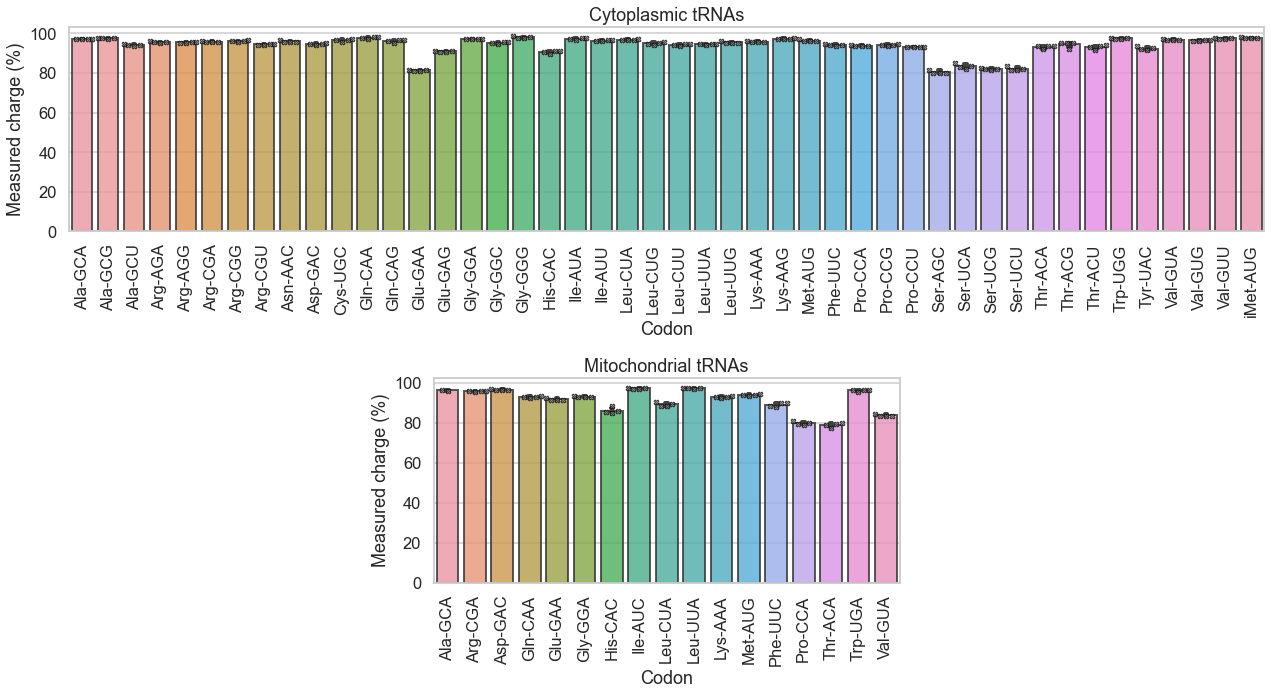

In [16]:
# Plot per codon charge:
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 7)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 2:5])

    # Plot for cyto:
    cyto_mask = (~charge_df['mito_codon']) & (~charge_df['Ecoli_ctr']) & (charge_df['sample_name'] == '100p_0m') & (charge_df['RPM'] > 1000)
    plot_df = charge_df[cyto_mask].groupby(['AA_codon', 'replicate']).agg(charge_mean=('charge', 'mean')).reset_index()
    g1 = sns.barplot(ax=ax1, data=plot_df, x='AA_codon', y='charge_mean', \
                     capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8)
    g1 = sns.swarmplot(ax=ax1, data=plot_df, x='AA_codon', y='charge_mean', \
                       color='grey', alpha=0.8, edgecolor='black', linewidth=0.8, \
                       size=5, marker="X", warn_thresh=1)
    g1.set(xlabel='Codon', ylabel='Measured charge (%)')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
    g1.set_title('Cytoplasmic tRNAs')

    # Plot for mito:
    mito_mask = (charge_df['mito_codon']) & (~charge_df['Ecoli_ctr']) & (charge_df['sample_name'] == '100p_0m') & (charge_df['RPM'] > 1000)
    plot_df = charge_df[mito_mask].groupby(['AA_codon', 'replicate']).agg(charge_mean=('charge', 'mean')).reset_index()
    g2 = sns.barplot(ax=ax2, data=plot_df, x='AA_codon', y='charge_mean', \
                     capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8)
    g2 = sns.swarmplot(ax=ax2, data=plot_df, x='AA_codon', y='charge_mean', \
                       color='grey', alpha=0.8, edgecolor='black', linewidth=0.8, \
                       size=5, marker="X", warn_thresh=1)
    g2.set(xlabel='Codon', ylabel='Measured charge (%)')
    g2.set_xticklabels(g2.get_xticklabels(), rotation=90)
    g2.set_title('Mitochondrial tRNAs')
    fig.tight_layout()
    fig.savefig('data/plotting/baseline_codon_charge.pdf', bbox_inches='tight')

The charge of each codon is, as expected, high for almost all tRNAs derived from fresh tissue culture cells in complete media.
A few exceptions are apparent: in the cytoplasm all the four serine codons and Glu-GAA are low.
This is similar to observations made in Evans et al. 2017 that also showed low charge for serine codons.
As for the GAA codon this is also one of the most common codons form ribosomal stalling (Ingolia et al 2011, Cell).
The mitochondrial codon charge is more variable (also seen in Evans et al. 2017) but we have no reason to believe this is due to artifacts in the assay.


### Predicted vs. measured tRNA charge
As described in the above protocol, the RNA concentrations were measured and adjusted before mixing a known ratio of intact and deacylated RNA; however, it is not given that the RNA concentration is 100% accurate and it is also not known whether some tRNAs are preferentially accumulating as a result of the deacylation step.
We will remain agnostic to both of these possibilities by assuming that the concentration of each tRNA transcript is unknown in the deacylated sample.

Let $A$ represent intact RNA and $B$ represent deacylated RNA.
Assume the concentration of a tRNA transcript $i$ in the intact RNA as $1$:
$$
C^A_i = 1
$$
While letting the concentration of the same tRNA transcript in the deacylated RNA be unknown:
$$
C^B_i = F_i <=> F_i = \frac{C^B_i}{C^A_i}
$$

Define $T^A_i$ as the average measured charge of the intact tRNA of a transcript $i$
$$
T^A_i = \text{Avg charge}(A_i)
$$
And similarily for deacylated RNA:
$$
T^B_i = \text{Avg charge}(B_i)
$$

Now, the predicted charge of a mixture of $A$ and $B$ can be defined using $p$ to describe the percentage of $A$ in the mixture:
$$
T^{AB}_i(p) = \frac{p T^A_i + (100-p) T^B_i F_i}{p + (100-p) F_i}
$$

In the above, only $F_i$ is unknown.
The titration was made with 8 different mixing ratios, two of which are used to fix the upper/lower bounds of the predicted charge, thus leaving 6 mixing ratios, each with several barcode replicates, to fit $F_i$ such that the squared difference between predicted and measured charge is minimized.

Alternatively, instead of fitting $F_i$ using the charge data it can be calculated using the abundance data.
tRNA abundance is measured by read counts which are relative to the sequencing depth and therefore normalized as reads per million (RPM).
The RPM value for each transcript is then normalized to the RPM value of the E.coli spike-in control to get a pseudo-quantitative metric:
$$
R^A_i = \frac{\text{RPM}^A_i}{\text{RPM}^A_{ecoli}}
$$

$F_i$ can then be calculated as:
$$
F_i = \frac{R^B_i}{R^A_i}
$$


Below, both approaches are implemented and compared.

In [17]:
# Function to infer and calculate the concentration of deacylated
# compared to intact RNA (correction factor)
# including plotting of the results.
def infer_FB(df, tRNA_name, BFGS_loss_func=loss_func_l2, plot_return=True, plot_fh=None):
    # Extract information for the fit:
    x = df['percent_charged'].values # "p" above
    y = df['charge'].values          # The measured charge
    A_charge = y[x==100].mean()      # "TA_i" above
    B_charge = y[x==0].mean()        # "TB_i" above
    
    # Input realistic bounds (4x either direction)
    # and use no difference as initial guess:
    bnds = ((0.25, 4), )
    guess = (1, )
    # Do the minimization with BFGS:
    def fun_F(p): return(obj_F_fit(BFGS_loss_func, x, y, A_charge, B_charge, p))
    p_fun_FB = minimize(fun_F, guess, method='L-BFGS-B', bounds=bnds)
    FB_inferred = p_fun_FB.x[0]
    # Calculate the signed prediction error
    # this would be percentage point deviation:
    x_trans = x_trans_fun(x, A_charge, B_charge, FB_inferred)
    pred_err = y - x_trans
    df['pred_err'] = pred_err
    
    # "Calculate" the correction factor
    # using the e.coli spike-in normalized RPM values:
    ms = (x < 100) # drop 100p samples b/c e.coli control was added at different quantity
    y2 = df['RPM_norm'].values
    # Make a linear fit to use all data to better
    # predict normalized RPM:
    A = np.vstack([x[ms], np.ones(len(x[ms]))]).T
    slope, intersection = np.linalg.lstsq(A, y2[ms], rcond=None)[0]
    # Calculate the correction factor:
    rpm0_pred = intersection
    rpm100_pred = intersection + 100*slope
    FB_calculated = rpm0_pred/rpm100_pred
    

    ### Plotting ###
    fig = plt.figure(figsize=(16, 5))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1.3, 1])
    
    # Predicted vs. measured using "inferred" correction factor:
    ax1 = fig.add_subplot(gs[0, 0])
    g1 = sns.scatterplot(ax=ax1, x=x_trans, y=y, zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7)
    g1.set_title('Factor inferred {:.2f}'.format(FB_inferred))
    g1.set(xlabel='Predicted charge (%)', ylabel='Measured charge (%)')
    ax1.plot(x, x, c='r', zorder=1)
    
    # Prediction error broken down by barcode:
    with sns.axes_style("whitegrid"):
        ax2 = fig.add_subplot(gs[0, 1])
        bc_order = sorted(set(df['barcode']))
        g2 = sns.boxplot(ax=ax2, data=df, x='barcode', y='pred_err', boxprops=dict(alpha=0.8), \
                         order=bc_order, fliersize=False, zorder=10)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.swarmplot(ax=ax2, data=df, x='barcode', y='pred_err', size=4, \
                      order=bc_order, color='white', alpha=0.8, edgecolor='black', \
                      linewidth=0.8, marker="X", zorder=11)
    g2.set_title('Barcode bias')
    g2.set(xlabel='Barcode', ylabel='Error (mes - pred; %)')

    # Normalized RPM data and linear fit to
    # generate the "calculated" correction factor:
    ax3 = fig.add_subplot(gs[0, 2])
    g3 = sns.scatterplot(ax=ax3, x=x[ms], y=y2[ms], zorder=11, alpha=0.5, \
                         edgecolor='black', linewidth=0.7)
    g3.set_title('Factor calculated {:.2f}'.format(FB_calculated))
    g3.set(xlabel='Intact tRNA in mix (%)', ylabel='RPM (norm. to spike-in)')
    y2_pred = intersection + slope*x
    ax3.plot(x, y2_pred, c='r', zorder=1)
    
    fig.suptitle('{}'.format(tRNA_name), size=17);
    fig.tight_layout()

    # Save plots:
    if not plot_fh is None:
        plot_fh.savefig(fig, bbox_inches='tight')
    else:
        fig.savefig('data/plotting/{}.pdf'.format(tRNA_name), bbox_inches='tight')
    if plot_return is False:
        plt.close(fig)
    
    return((FB_inferred, FB_calculated), pred_err)


# Objective function for fitting the F_i variable:
def obj_F_fit(loss_func, x, y, A_charge, B_charge, p):
    F = p[0]
    x_trans = x_trans_fun(x, A_charge, B_charge, F)

    loss = sum(loss_func(y, x_trans))
    return(loss)

# Function to calculate the predicted charge:
def x_trans_fun(x, A_charge, B_charge, F):
    return((x*A_charge + (100-x)*F*B_charge) / (x + (100-x)*F))


In [18]:
# Run analysis on titration data
# one tRNA transcript at the time:
FB_res = list()
pred_list = list()
index_list = list()
anno_list = list(tann_sele)
with PdfPages('data/plotting/titration-fit.pdf') as pp:
    for tann in anno_list:
        # Extract dataframe with single tRNA annotation:
        sample_mask = (titr_df['tRNA_annotation'] == tann)
        titr_spl = titr_df[sample_mask].copy()
        tann_short = titr_spl['tRNA_anno_short'].drop_duplicates().values[0]

        # Perform correction factor inference and plot:
        FB_tup, pred_err = infer_FB(titr_spl, tann_short, plot_fh=pp, plot_return=False)
        FB_res.append(FB_tup)
        pred_list.extend(pred_err)
        index_list.extend(titr_spl.index.values)

# Correction factor "inferred" and "calculated" to dataframe:
FB_df = pd.DataFrame(FB_res).rename(columns={0: 'Inferred', 1: 'Calculated'})
FB_df['tRNA_annotation'] = anno_list
FB_df = FB_df.merge(titr_df.loc[:, ['tRNA_annotation', 'tRNA_anno_short', 'tRNA_annotation_len', \
                                    'codon', 'anticodon', 'AA_codon', 'amino_acid', 'AA_letter', \
                                    'mito_codon', 'Ecoli_ctr']], \
                    on='tRNA_annotation').drop_duplicates().reset_index(drop=True)

# Prediction error to dataframe:
titr_df.loc[index_list, 'pred_err'] = pred_list

We can check the results by looking at the fit for a random trancript.
The left scatterplot shows the predicted vs. measured charge using the inferred correction factor to make the prediction.
The red line shows a perfect 1:1 fit.
The middle boxplot shows the prediction error of the left plot broken down by barcode.
The right scatterplot shows the E.coli spike-in normalized RPM values as a function of the percentage of deacylated tRNA in the mixture.
The linear fit used to calculated the correction factor is shown as a red line.

The plot in the right shows that the normalized RPM values are quite variable, probably because this number is affected by the variance of both the RPM value of the transcript and the RPM value of the E.coli spike-in.
It is clear from the left plot that the charge titration is highly linear and close to the predicted charge values.
This means that tRNA charge can be quantified reliably for this tRNA transcript.

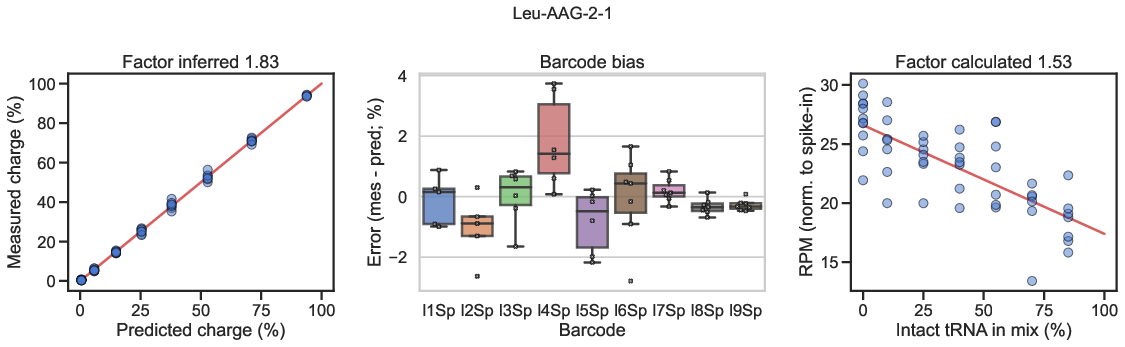

In [19]:
random_image = np.random.randint(len(anno_list))
img = WImage(filename='data/plotting/titration-fit.pdf[{}]'.format(random_image))
img

Looking at the "inferred" vs "calculated" abundance correction factor there is a clear correlation but it deviates from the expected 1:1 proportionality marked by a red line.
The reason for this deviation is unknown.

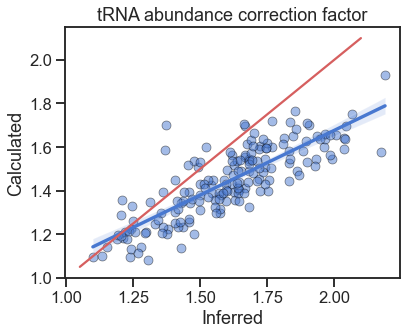

In [20]:
# Plot inferred vs. calculated correction factor:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

g1 = sns.regplot(ax=ax1, data=FB_df, x='Inferred', y='Calculated', \
                 scatter_kws=dict(alpha=0.5, edgecolor='black', linewidth=0.7))
g1.set(xlabel='Inferred', ylabel='Calculated')
g1.set_title('tRNA abundance correction factor')
ax1.plot([1.05, 2.1], [1.05, 2.1], c='r')
fig.tight_layout()
fig.savefig('data/plotting/correction-factor.pdf', bbox_inches='tight')

### Analyzing the prediction errors

The barcode bias summarized over all the tRNA annotations can give us a clue as to whether any barcode is problematic.
In this case, the boxplot shows that barcode 4 (l4Sp) is slightly biased towards higher measured charge which could be because the adapter with this barcode has a slight ligation preference towards CCA as opposed to CC.
All the other barcodes have a tight error distribution around or close to zero and thus not showing any ligation bias.

Breaking the prediction error down based on the fraction of deacylated RNA or sequencing run batch shows no concerning trends.

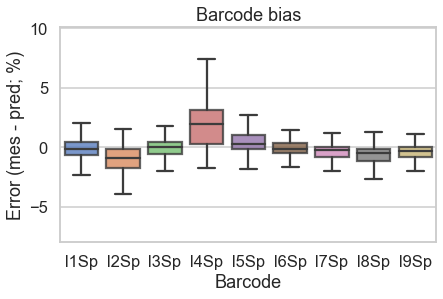

In [21]:
# Plot the prediction error for all the tRNA annotations
# broken down by barcode:
bc_order = sorted(set(titr_df['barcode']))
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 4.5))
    g1 = sns.boxplot(ax=ax1, data=titr_df, x='barcode', y='pred_err', \
                     boxprops=dict(alpha=0.8), order=bc_order, fliersize=False)

g1.set(xlabel='Barcode', ylabel='Error (mes - pred; %)')
g1.set_title('Barcode bias')
fig.tight_layout()
fig.savefig('data/plotting/barcode_prediction-error.pdf', bbox_inches='tight')

# And dump the data summary as an Excel file:
titr_df.loc[:, ['barcode', 'pred_err']].pivot(columns='barcode').describe().to_csv('barcode-bias_summary.csv')

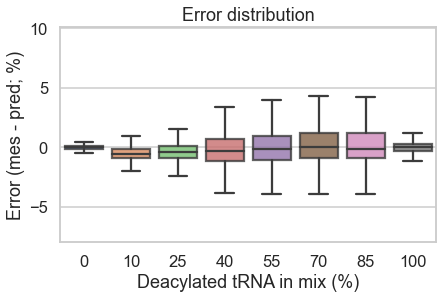

In [22]:
# Plot the prediction error for all the tRNA annotations
# broken down by the percentage :
ch_order = sorted(set(titr_df['percent_charged']))
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 4.5))
    g1 = sns.boxplot(ax=ax1, data=titr_df, x='percent_charged', y='pred_err', \
                     boxprops=dict(alpha=0.8), fliersize=False)

g1.set(xlabel='Deacylated tRNA in mix (%)', ylabel='Error (mes - pred; %)')
g1.set_title('Error distribution')
fig.tight_layout()
fig.savefig('data/plotting/percent-deacyl_prediction-error.pdf', bbox_inches='tight')

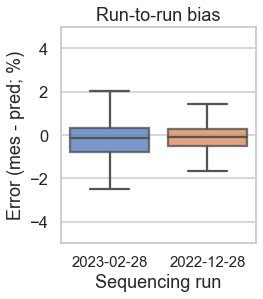

In [23]:
# Run-to-run bias:
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(4, 4.5))
    g1 = sns.boxplot(ax=ax1, data=titr_df, x='run_v1', y='pred_err', \
                     boxprops=dict(alpha=0.8), fliersize=False)
g1.set_xticklabels(['2023-02-28', '2022-12-28'], rotation=0, size=15)
g1.set(xlabel='Sequencing run', ylabel='Error (mes - pred; %)', ylim=(-5, 5))
g1.set_title('Run-to-run bias')
fig.tight_layout()
fig.savefig('data/plotting/run-to-run_prediction-error.pdf', bbox_inches='tight')

### Investigating the variables influencing tRNA abundance after deacylation treatment
The correction factors inferred above range between 1.1 and 2.2, thus suggesting that during the deacetylation process some transcripts were depleted and some enriched.
It would be useful to know what caused this depletion/enrichment.

In the following section, we will apply a simple linear regression model to test if the magnitude of the correction factor can be predicted from the amino acid identity, tRNA length and whether it is a mito or cyto tRNA.

In [24]:
FB_df.head(3)

,Inferred,Calculated,tRNA_annotation,tRNA_anno_short,tRNA_annotation_len,codon,anticodon,AA_codon,amino_acid,AA_letter,mito_codon,Ecoli_ctr
0,1.651857,1.488741,Homo_sapiens_tRNA-Gly-CCC-2-1,Gly-CCC-2-1,74,GGG,CCC,Gly-GGG,Gly,G,False,False
1,1.353252,1.297158,Homo_sapiens_tRNA-Thr-CGT-3-1,Thr-CGT-3-1,77,ACG,CGT,Thr-ACG,Thr,T,False,False
2,1.674766,1.612968,Homo_sapiens_tRNA-Ile-AAT-2-1,Ile-AAT-2-1,77,AUU,AAT,Ile-AUU,Ile,I,False,False


In [25]:
# Run OLS:
results = smf.ols('Inferred ~ tRNA_annotation_len + amino_acid + mito_codon', data=FB_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Inferred   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     10.23
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           9.11e-21
Time:                        14:59:36   Log-Likelihood:                 89.814
No. Observations:                 175   AIC:                            -131.6
Df Residuals:                     151   BIC:                            -55.67
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8270    

The regression shows a bad fit.
Most independent variables are not significantly improving the model $(P>|t|)$ and the R-squared is low considering the large amount of variables.
Nevertheless, select the signification variables, refit the model and plot the predictions vs. true values:

In [26]:
endog = pd.DataFrame(results.model.endog, columns=[results.model.endog_names])
exog = pd.DataFrame(results.model.exog, columns=results.model.exog_names)
cols_sele = ['Intercept', 'amino_acid[T.Arg]', 'amino_acid[T.Asn]', 'amino_acid[T.Cys]', \
'amino_acid[T.Ile]', 'amino_acid[T.Leu]', 'amino_acid[T.Pro]', 'amino_acid[T.Thr]', \
'amino_acid[T.Trp]', 'amino_acid[T.Val]', 'amino_acid[T.iMet]']
results = sm.OLS(endog, exog=exog.loc[:, cols_sele]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Inferred   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     20.19
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           5.41e-24
Time:                        14:59:36   Log-Likelihood:                 77.856
No. Observations:                 175   AIC:                            -133.7
Df Residuals:                     164   BIC:                            -98.90
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.5159      0

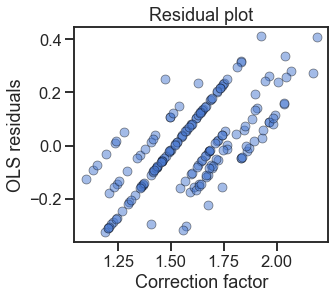

In [27]:
# Plot OLS fit and diagnostics:
fig = plt.figure(figsize=(5, 4.5))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])

# OLS residuals:
g1 = sns.scatterplot(ax=ax1, y=results.resid, x=FB_df['Inferred'], \
                     zorder=10, alpha=0.5, \
                     edgecolor='black', linewidth=0.7, legend=False)
g1.set_title('Residual plot')
g1.set(ylabel='OLS residuals', xlabel='Correction factor')

fig.tight_layout()

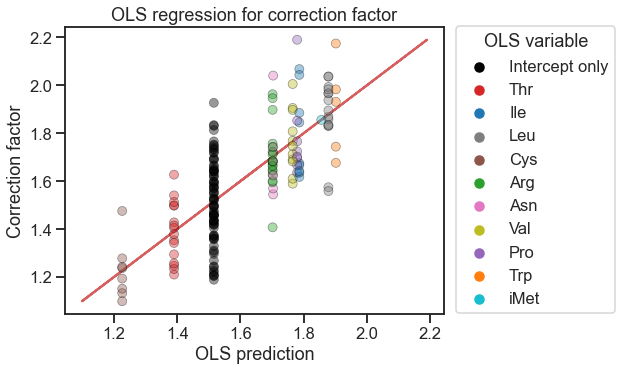

In [28]:
# Plot the regression results:
FB_df['Inferred_fitted'] = results.fittedvalues.values
aa_sele = {'Arg', 'Asn', 'Cys', 'Ile', 'Leu', 'Pro', 'Thr', 'Trp', 'Val', 'iMet'}
AArgb_dict = dict()
cmap_b = mpl.colormaps['tab10']
for aai, aa in enumerate(aa_sele):
    AArgb_dict[aa] = cmap_b(aai)

color_list = list()
aa_sele_list = list()
for aa in FB_df['amino_acid']:
    if aa in aa_sele:
        color_list.append(AArgb_dict[aa])
        aa_sele_list.append(aa)
    else:
        color_list.append((0,0,0,1))
        aa_sele_list.append('Intercept only')

FB_df['Variable'] = aa_sele_list
sns_palette = {aa:col for aa, col in zip(aa_sele_list, color_list)}

fig, ax1 = plt.subplots(1, 1, figsize=(9, 5.5))
g1 = sns.scatterplot(ax=ax1, data=FB_df, x='Inferred_fitted', y='Inferred', \
                     alpha=0.4, hue='Variable', \
                     edgecolor='black', linewidth=0.7, \
                     palette=sns_palette, \
                     zorder=10)
sns.move_legend(g1, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=1, title='OLS variable')
ax1.plot(FB_df['Inferred'].values, FB_df['Inferred'].values, \
         color='r', zorder=1)
g1.set(xlabel='OLS prediction', ylabel='Correction factor')
g1.set_title('OLS regression for correction factor')
fig.tight_layout()
fig.savefig('data/plotting/correction-factor_OLS-prediction.pdf', bbox_inches='tight')

The plot makes it clear how bad the prediction is; however, it does show that tRNAs with Cys/Thr codons have mean correction factors lower than average i.e. depletion and conversely that the other amino acid variables, and especially Leu/Trp, have higher correction factors than average i.e. enrichment.

We could employ better methods for variable selection such as rigde and LASSO regression; however, these just remove all the variables because of their low influence (did try though).
In the end, it remains unknown what makes the acylated and deacylated tRNA have such different tRNA content at the transcript level. But luckily, there is enough dilutions on the titration curve to infer an abundancen correction factor for each transcript, solving the problem and enabling the finding of the linear range of charge measurements.
Such correction factor can of course not be calculated for single samples and therefore the observation that the deacylation procedure affected the apparent tRNA transcript abundance shows that to compare relative expression levels between samples one must carefully apply the same conditions to all samples and use technical replicates to minimize false positives.



### Concluding discussion of the five failure modes

By now, we have addressed each of the five failure modes with the following summary:

1. Oxidation does not run to completion => charge overestimate
    * Tested with an E.coli spike-in for all samples and a set of fully deacylated samples. Data support the oxidation to be somewhere between 99-100% complete. Apparent incomplete oxidation can be explained by other factors such as errors in the CCA-end attachment.
2. Base cleavage/dephosphorylation does not run to completion => charge overestimate
    * Tested by various RNA gels on synthetic oligo tRNA and tRNAs isolated from cell lines. These gels support that ligation goes to completion and thus cleavage/dephosphorylation must also be complete. It is hard to test with sequencing data (see discussion below) but time samples to determine the aminoacylation half-life does not support a large fraction of incomplete cleavage/dephosphorylation.
3. Low RNA integrity => charge underestimate
    * Tested routinely by RNA gels and through non-oxidized control samples. Data support high RNA integrity with minimal to no effect on charge measurements. Non-oxidized control samples suggest an upper bound of +/- 0.5% effect on charge measurements.
4. Adapter ligation is biased => charge overestimate
    * Tested with RNA gel of ligation reaction and by data comparing measured vs. predicted charge broken down by barcoded adapters. RNA gels suggest that ligation goes to completion and data support no preference in acylated vs. deacylated substrate for ligation, with the exception of adapter l4Sp, which shows a slight preference for CCA ligation (yielding higher charge measurements).
5. Deacylation is incomplete => charge underestimate
    * Tested using deacylated control samples. Data support that >99% of tRNAs are deacylated with the exception of fMet-tRNAs which had 5-7% charge remaining. This could be improved by doubling the deacylation incubation time to 8 hours; however, this comes at the cost of reduced RNA integrity which would influence the charge measurement in other ways.


Most of these failure modes were addressed using real data from hundreds of human tRNA transcripts.
We consider such evidence stronger than that from synthetic oligos.
However, point two, on incomplete cleavage/dephosphorylation, is hard to test with sequencing data because it would require knowing the true charge of the tRNAs in a sample.
If cleavage/dephosphorylation is incomplete the deacylated RNA should appear as *lower* abundance compared to intact RNA i.e. the opposite of what we observed in the charge titration samples; if the correction factor $F$ was due to incomplete cleavage/dephosphorylation it would be expected to be smaller than 1.
However, if we imagine that the deacylated RNA is generally more enriched in tRNA, maybe because of the purification process after deacylation, then a correction factor larger than one could be consistent with incomplete cleavage/dephosphorylation.
In that case the completeness of cleavage/dephosphorylation is dependent on the tRNA sequence, which is rather odd considering that the universal CCA-end provides the same context for lysine cleavage and that dephosphorylation is very rapid and efficient; furthermore, this is not supported by a high degree of proportionality in the RPM values of oxidized vs. non-oxidized sample (see the notebook in the `charge_half-life` folder under projects).
Incomplete cleavage/dephosphorylation would also result in larger amounts of unligated tRNA for deacylated tRNA samples, something not supported by experiments.
In summary, although harder to prove, many pieces of evidence all points in the same direction: that cleavage/dephosphorylation is running to completion.
